In [32]:
#---------------------- Header 
from easydict import EasyDict
import os
import json
args = EasyDict()

#------ image list 
i_1 = "/mnt/hdd/eric/.tmp_ipy/00.Data/AO/0-Pusan-2023-AO/C1_20230111015112_10034_00006119_L1G_PS/0-Pusan-2023-AO_2_C1_20230111015112_10034_00006119_L1G_PS.png"

#------ tif list 
t_1 = "/mnt/hdd/eric/.tmp_ipy/00.Data/AO/0-Pusan-2023-AO/C1_20230111015112_10034_00006119_L1G_PS/C1_20230111015112_10034_00006119_L1G_PRGB.tif"

#------ gpu
args.gpu_id = 0

#------ model 
args.img_path = i_1

print( '/'.join( args.img_path.split("/")[0:-1]) )
args.infer_threshold = 0.2
args.infer_threshold_showing = 0.2
source_root ='/'.join( args.img_path.split("/")[0:-1])

args.img_output = args.img_path.replace(".png" ,"_output_v1_1213.png")
args.img_output_masked = args.img_path.replace(".png" ,"_output_v1_1213_Masked.png")
args.img_output_scatter = args.img_path.replace(".png" ,"_output_v1_1213_Scatter.png")

args.csv_output = args.img_path.replace(".png","_v1_1213.csv")
args.csv_output_masked =args.img_path.replace(".png","_masked_v1_1213.csv")
args.csv_output_scatter = args.img_path.replace(".png","scatter_v1_1213.csv")

#------ Coordinates filtering function
args.txt_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/AO/0-Pusan-2023-AO/C1_20230111015112_10034_00006119_L1G_PS/1RCoordinate.txt"

args.xml_path = None

#------ Map Shape 
# old mask
#args.map_path = os.path.join(source_root, "map")
#args.map_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/Shape_Old"
# new mask 
args.map_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/Shape_Korea_Clipped"


#------ TIF 
args.tf_path = t_1

# time 2023 05 23 04 50 50
args.year_= int( i_1 .split("/")[-2].split("_")[1][0:4])
args.month_ = int(i_1 .split("/")[-2].split("_")[1][4:6])
args.day_ = int(i_1 .split("/")[-2].split("_")[1][6:8])
hour_ = int(i_1 .split("/")[-2].split("_")[1][8:10])
args.hour_ = hour_ + 9
args.min  = int(i_1 .split("/")[-2].split("_")[1][10:12]) 
args.sec =  0
print("time : ", args.year_, args.month_, args.day_, args.hour_, args.min)

#------ AIS csv 
args.data_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/AIS-CSV-NTO-AO/2차-11개/202301111000_dynamic.csv"
args.static_data_path = args.data_path.replace("_dynamic.csv","_static.csv")
args.final_merge = args.img_path.replace(".png",".csv")

# time gap
# 시각화 결과물에서 ais 좌표가 해상도가 더 높아지게 된다. 
args.time_gap_min = 5
args.time_gap_sec = False

# pixel gap 
# this is for visualization
args.pixel_gap = 200

# # latlon gap 
# # 매칭되는 박스와 ais 간의 기준 => 늘리면 R_ 데이터프레임에서 매칭 케이스가 늘어나게 된다. 
# args.latlon_gap = 0.000001

#------ Model Inference 
args.model_test = False
args.Box_Matching = True
args.png_draw_save = True


# Save EasyDict to a file
file_path = os.path.join(source_root ,"config.json" )
with open(file_path, 'w') as json_file:
    json.dump(args, json_file, indent=4)

/mnt/hdd/eric/.tmp_ipy/00.Data/AO/0-Pusan-2023-AO/C1_20230111015112_10034_00006119_L1G_PS
time :  2023 1 11 10 51


In [2]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = 933120000
from adjustText import adjust_text

# Draw image 
img_path = args.img_path
img_ = Image.open(img_path)

In [3]:
img_.size

(29400, 28840)

# 1. Model Inference

In [4]:
import testModule

if args.model_test:
    result = testModule.infer_model(input_file_path=args.img_path,\
                        thres=args.infer_threshold , gpu_id = 0)

In [5]:
#------------------------
# result save
import numpy as np
import os 
save_root = "/mnt/hdd/eric/.tmp_ipy/00.Data/Inference_results"
file_name = args.img_path.split("/")[-1].split(".")[0]+".npy"    

if args.model_test == False:
    result = np.load(os.path.join(save_root,file_name))
else:
    print("Result Saved")
    np.save(os.path.join(save_root,file_name), result)

# 2. AIS csv 

- time condition 에 맞게 filtering 

In [6]:
import pandas as pd

df = pd.read_csv(args.data_path)

In [7]:
#---- current time ----#
import datetime
year_= args.year_
month_ = args.month_ 
day_ = args.day_
hour_ = args.hour_
min  = args.min
sec =  args.sec
crit_time_str = f"{year_}-{month_}-{day_} {hour_}:{min}:{sec}"
date = pd.to_datetime(crit_time_str)

#---- time condition ----#
time_gap_min = args.time_gap_min
time_gap_sec = args.time_gap_sec

earl_time = date - datetime.timedelta(minutes=time_gap_min,seconds=time_gap_sec)
post_time = date + datetime.timedelta(minutes=time_gap_min,seconds=time_gap_sec)

print("early : ",earl_time)
print("now : ",date)
print("late : ",post_time)



early :  2023-01-11 10:46:00
now :  2023-01-11 10:51:00
late :  2023-01-11 10:56:00


In [8]:
df.columns

Index(['mmsi_', 'time', 'lon_', 'lat_', 'heading_', 'turn_', 'speed_'], dtype='object')

In [9]:
df.columns = ['mmsi_', 'time', 'long', 'lat', 'heading_', 'turn_', 'speed_']

In [10]:
df

mmsi_                 time        long        lat  heading_  turn_  \
0      440031780  2023-01-11 10:00:00  129.050863  35.123518       511 -128.0   
1      440216410  2023-01-11 10:00:00  129.050085  35.123078       511 -128.0   
2      440101370  2023-01-11 10:00:00  129.064133  35.126133       324    0.0   
3      440111320  2023-01-11 10:00:00  129.116220  35.083763       259  127.0   
4      440300740  2023-01-11 10:00:00  129.124815  35.083297       511 -128.0   
...          ...                  ...         ...        ...       ...    ...   
40906  440017100  2023-01-11 10:59:59  129.073892  35.037897        28 -128.0   
40907  440111320  2023-01-11 10:59:59  129.070780  35.098173       313 -128.0   
40908  273399580  2023-01-11 10:59:59  129.064543  35.098195        29 -128.0   
40909  440033880  2023-01-11 10:59:59  129.052705  35.125098       511 -128.0   
40910  440108720  2023-01-11 10:59:59  129.054852  35.105367       511 -128.0   

       speed_  
0         0.0  
1         0.0  
2         0.0  
3         8.8  
4         8.9  
...       ...  
40906     8.8  
40907     0.1  
40908     0.0  
40909     0.0  
40910     1.3  

[40911 rows x 7 columns]

In [11]:
#---- filtering datetime ---# 
# 
time_ = []
for i,row in df.iterrows():
    #print(row["time"])
    time_.append( pd.to_datetime( row["time"] ) )
df["datetime"] = time_

con1 = df["datetime"] < post_time 
con2 = df["datetime"] > earl_time

#--- exec ---#
time_filter_flag = True

if time_filter_flag:
    t_df = df.loc[con1 & con2] 
    df.loc[con1 & con2]
else:
    t_df = df
    t_df

In [12]:
t_df

mmsi_                 time        long        lat  heading_  turn_  \
31979  440800579  2023-01-11 10:46:01  129.109282  35.100092        45 -128.0   
31980  440314380  2023-01-11 10:46:01  129.094292  35.035320       511 -128.0   
31981  440328640  2023-01-11 10:46:01  129.065778  35.109160        84    0.0   
31982  440006000  2023-01-11 10:46:01  128.900300  34.717350       211    0.0   
31983  440054010  2023-01-11 10:46:01  129.075733  35.094373       511 -128.0   
...          ...                  ...         ...        ...       ...    ...   
38447  440030820  2023-01-11 10:55:59  129.034532  35.086593       511 -128.0   
38448  440127670  2023-01-11 10:55:59  129.068702  35.109990       511 -128.0   
38449  273399580  2023-01-11 10:55:59  129.064545  35.098192        29 -128.0   
38450  440053750  2023-01-11 10:55:59  129.094567  35.096900       511 -128.0   
38451  440052560  2023-01-11 10:55:59  129.066718  35.038237       511 -128.0   

       speed_            datetime  
31979     0.0 2023-01-11 10:46:01  
31980     0.2 2023-01-11 10:46:01  
31981     0.0 2023-01-11 10:46:01  
31982    16.2 2023-01-11 10:46:01  
31983    11.4 2023-01-11 10:46:01  
...       ...                 ...  
38447     0.0 2023-01-11 10:55:59  
38448     0.1 2023-01-11 10:55:59  
38449     0.0 2023-01-11 10:55:59  
38450     0.1 2023-01-11 10:55:59  
38451     9.6 2023-01-11 10:55:59  

[6473 rows x 8 columns]

# 3. Coordinates filtering


In [13]:
# Coordinates filtering function ! 

if args.txt_path != None:
    txt_path = args.txt_path
    f = open(txt_path,'r')
    lines = f.readlines()
    lines

    top_left =     lines[1]
    bottom_right = lines[-1]

    min_long = float( top_left.split(":")[1].split(",")[1][0:10] )
    max_long = float( bottom_right.split(":")[1].split(",")[1][0:10] ) 

    min_lat  = float( bottom_right.split(":")[1].split(",")[0][0:10] ) 
    max_lat  = float( top_left.split(":")[1].split(",")[0][0:10] ) 

elif args.xml_path != None:
    # XML parsing
    import xml.etree.ElementTree as ET

    xml_path = args.xml_path
    tree = ET.parse(args.xml_path)
    root = tree.getroot() 


    Top_left = []
    Bottom_right = []

    for child in root:
        if child.tag =="Image":
            print(child)
            for grand_child in child:
                if grand_child.tag =="PAN":
                    for gg_child in grand_child:
                        #print(gg_child.tag)
                        if gg_child.tag == "ImagingCoordinates":
                            for ggg in gg_child:
                                
                                if ggg.tag =="ImageGeogTL":
                                    # print(ggg.tag)                         
                                    # print(ggg[0].text)
                                    # print(ggg[1].text)
                                    Top_left.append(float(ggg[0].text))
                                    Top_left.append(float(ggg[1].text))
                                elif ggg.tag == "ImageGeogBR":
                                    # print(ggg.tag)                         
                                    # print(ggg[0].text)
                                    # print(ggg[1].text)
                                    Bottom_right.append(float(ggg[0].text))
                                    Bottom_right.append(float(ggg[1].text))
    
    min_long = Top_left[1]
    max_long = Bottom_right[1]
    min_lat = Bottom_right[0]
    max_lat = Top_left[0]

# 35.032614576
# 128.632902263
# ImageGeogBR
# 34.852878881
# 128.904069499

print(min_long,max_long,min_lat,max_lat)
                                

129.196753 129.357721 35.1097744 35.1915697


In [14]:
con1 = t_df["long"] > min_long
con2 = t_df["long"] < max_long

con3 = t_df["lat"] > min_lat
con4 = t_df["lat"] < max_lat + 0.0225 # debugged by eric 


#------------------------------------
location_filter_flag = True

if location_filter_flag == True:
    #q_df = df.loc[con1 & con2 & con3 & con4]
    q_df = t_df.loc[con1 & con2 & con3 & con4]
    q_df
else:
    q_df = df

In [15]:
q_df

mmsi_                 time        long        lat  heading_  turn_  \
31997  440110750  2023-01-11 10:46:02  129.224475  35.154448       511 -128.0   
32199  440124550  2023-01-11 10:46:17  129.268555  35.175565       190  127.0   
32241  440110750  2023-01-11 10:46:21  129.225205  35.155087       511 -128.0   
32457  440124550  2023-01-11 10:46:38  129.267817  35.174732       188    0.0   
32571  440061960  2023-01-11 10:46:47  129.303820  35.130333       209    0.0   
...          ...                  ...         ...        ...       ...    ...   
37918  440110750  2023-01-11 10:55:21  129.246540  35.175210       511 -128.0   
38161  440120970  2023-01-11 10:55:38  129.231388  35.161898       511 -128.0   
38210  440110750  2023-01-11 10:55:41  129.247197  35.176052       511 -128.0   
38308  440124550  2023-01-11 10:55:49  129.250537  35.151480       184    0.0   
38429  440124550  2023-01-11 10:55:58  129.250278  35.151092       184    0.0   

       speed_            datetime  
31997    10.5 2023-01-11 10:46:02  
32199    10.7 2023-01-11 10:46:17  
32241    10.5 2023-01-11 10:46:21  
32457    10.7 2023-01-11 10:46:38  
32571    10.6 2023-01-11 10:46:47  
...       ...                 ...  
37918    10.7 2023-01-11 10:55:21  
38161    14.7 2023-01-11 10:55:38  
38210    10.5 2023-01-11 10:55:41  
38308    10.5 2023-01-11 10:55:49  
38429    10.8 2023-01-11 10:55:58  

[94 rows x 8 columns]

In [16]:
import utm
import rasterio

#-------------------
# utm => pixels 
#------------------
utm_array =[] # long lat 
#--- csv 
# latlong --> utm
for lat,lon in zip(q_df['lat'].values,q_df['long'].values):
    #print(lat)
    # if lat < 80:
    res = utm.from_latlon(lat,lon,52,"N")
    utm_array.append(res)

# 전환한 utm_array 를 데이터프레임에 병합 
q_df['utm_array']= utm_array


pixels_=[] # utm_array 를 pixels_ 로 변경 
tf_path = args.tf_path
with rasterio.open(tf_path) as map_layer:

    for inp in utm_array:
    
        coords2pixels = map_layer.index(inp[0],inp[1]) #input lon,lat # 좌표계 
        pixels_.append(coords2pixels)

q_df['pixels'] = pixels_

#--- init index in q_df
q_df.drop_duplicates(inplace=True)
q_df.reset_index(inplace=True,drop=True)


<ipython-input-16-06a44a921bcb>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q_df['utm_array']= utm_array
<ipython-input-16-06a44a921bcb>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q_df['pixels'] = pixels_
<ipython-input-16-06a44a921bcb>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q_df.drop_duplicates(inpl

In [18]:
# # remove duplicate row 
# [i[1:-1] for i in q_df['time']]
# # pd.to_datetime( )

In [35]:
q_df

mmsi_                 time        long        lat  heading_  turn_  \
0   440110750  2023-01-11 10:46:02  129.224475  35.154448       511 -128.0   
1   440124550  2023-01-11 10:46:17  129.268555  35.175565       190  127.0   
2   440110750  2023-01-11 10:46:21  129.225205  35.155087       511 -128.0   
3   440124550  2023-01-11 10:46:38  129.267817  35.174732       188    0.0   
4   440061960  2023-01-11 10:46:47  129.303820  35.130333       209    0.0   
..        ...                  ...         ...        ...       ...    ...   
89  440110750  2023-01-11 10:55:21  129.246540  35.175210       511 -128.0   
90  440120970  2023-01-11 10:55:38  129.231388  35.161898       511 -128.0   
91  440110750  2023-01-11 10:55:41  129.247197  35.176052       511 -128.0   
92  440124550  2023-01-11 10:55:49  129.250537  35.151480       184    0.0   
93  440124550  2023-01-11 10:55:58  129.250278  35.151092       184    0.0   

    speed_            datetime  \
0     10.5 2023-01-11 10:46:02   
1     10.7 2023-01-11 10:46:17   
2     10.5 2023-01-11 10:46:21   
3     10.7 2023-01-11 10:46:38   
4     10.6 2023-01-11 10:46:47   
..     ...                 ...   
89    10.7 2023-01-11 10:55:21   
90    14.7 2023-01-11 10:55:38   
91    10.5 2023-01-11 10:55:41   
92    10.5 2023-01-11 10:55:49   
93    10.8 2023-01-11 10:55:58   

                                          utm_array          pixels  
0   (520445.16945715627, 3890194.0394042707, 52, N)   (13602, 5054)  
1     (524453.6604638698, 3892545.852977535, 52, N)   (8898, 13071)  
2   (520511.49754966324, 3890265.0543035045, 52, N)   (13460, 5187)  
3    (524386.7094070025, 3892453.2922233758, 52, N)   (9083, 12937)  
4    (527680.0901564516, 3887538.8854291746, 52, N)  (18912, 19524)  
..                                              ...             ...  
89   (522449.1462896056, 3892501.2925320314, 52, N)    (8987, 9062)  
90  (521072.88488470967, 3891021.6821854757, 52, N)   (11946, 6310)  
91    (522508.73865265574, 3892594.81862878, 52, N)    (8800, 9181)  
92    (522819.7284016056, 3889870.555678601, 52, N)   (14249, 9803)  
93    (522796.24599957286, 3889827.46737869, 52, N)   (14335, 9756)  

[94 rows x 10 columns]

In [20]:
q_df.to_csv(args.csv_output_scatter,index=False)

In [42]:
bboxes_.__len__()

184

In [44]:
for b in bboxes_:
    print(b[5])

0.98310226
0.9674448
0.9610507
0.96011406
0.95914483
0.9564151
0.9541299
0.9467818
0.9466365
0.94370466
0.94003963
0.93949354
0.9342757
0.93171227
0.9306878
0.929107
0.924248
0.9237139
0.9171885
0.91565996
0.9116197
0.904472
0.8682166
0.86627966
0.8612378
0.8476027
0.8264531
0.82524186
0.82467717
0.82323974
0.8220101
0.81645095
0.81410635
0.81055266
0.8087616
0.80231774
0.7982939
0.79527587
0.79490584
0.79164904
0.786129
0.77969855
0.76922035
0.76589435
0.7618233
0.76007986
0.75833493
0.75510734
0.75491065
0.7539032
0.75195146
0.7467775
0.7381885
0.73514223
0.72757787
0.72663414
0.72436315
0.7236655
0.7234136
0.7232922
0.71748245
0.7139638
0.7101318
0.70600957
0.69856274
0.692715
0.68366534
0.677004
0.6643433
0.6569712
0.64978385
0.6492763
0.64920795
0.64742637
0.6458819
0.6405581
0.637495
0.63260883
0.63225734
0.6291638
0.62719876
0.6246654
0.60784066
0.60373545
0.6023147
0.5992178
0.5967147
0.5939128
0.55999804
0.54714805
0.54428816
0.5336562
0.5215054
0.5205891
0.5133756
0.5077818
0

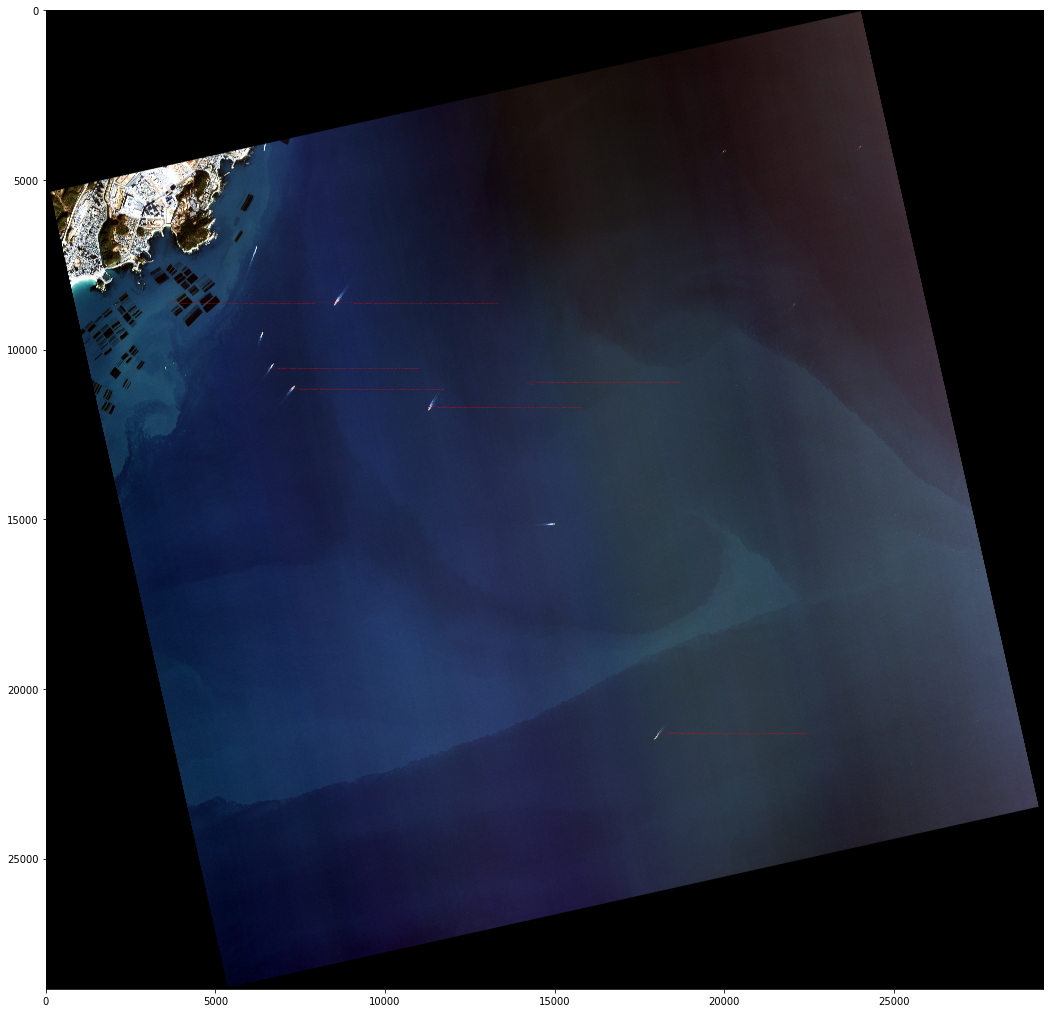

In [45]:
#------------------------------
# AIS matching with Bbox

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
from PIL import Image
Image.MAX_IMAGE_PIXELS = 933120000
from adjustText import adjust_text

# Draw image 
img_path = args.img_path
img_ = Image.open(img_path)
plt.figure(figsize=(18,18))
#plt.imshow(img_)
ax = plt.gca()

# Bounding Box 
# Thresholding filtering 
bboxes_ = [] 
cnt = 0
for r in result[0]:
    if r[-1] > args.infer_threshold_showing:
        cnt+=1
        bboxes_.append(r)

#----------------------------------------------------- 
# BBox matching with AIS 

# Matched Bbox
idx_bboxes = []
x_bboxes = [] 
y_bboxes = []
width_bboxes = []
height_bboxes = []
angle_bboxes = []
prob_bboxes= []

# Matched AIS 
x_matched_ais = []
y_matched_ais = []
time_matched_ais = []
idxss_matched_ais = []
lat_matched_ais = []
long_matched_ais = []

mmsi_matched_ais = []
heading_matched_ais = []
turn_matched_ais = []
speed_matched_ais = []


# 데이터들은 q_df 써서 활용하는 것을 원칙으로 한다. 
x_ais = [i[1] for i in q_df["pixels"].values]
y_ais = [i[0] for i in q_df["pixels"].values]
lat_ais  = [i for i in q_df['lat'].values]
long_ais = [i for i in q_df['long'].values]
mmsi_ = [i for i in q_df['mmsi_'].values]
heading_ = [i for i in q_df['heading_'].values]
turn_ = [i for i in q_df['turn_'].values]
speed_ = [i for i in q_df['speed_'].values]

idx_ais = [i for i in q_df.index.values]
time_ais = [i[1:-1] for i in q_df['time']]


for bidx, box_ in enumerate( bboxes_):
    x = box_[0]
    y = box_[1]
    width =  box_[2]
    height = box_[3]
    angle_ = box_[4]
    prob_  = box_[5]
    

    # model 의 객체좌표가 center 중심인데, patches.Rectangle 은 좌하단을 기준점으로 보기 때문에. x,y 를 아래와 같이 shift 
    # roatate 할 때, 중심좌표 center 로 잡고, angle radian 변환해서 넣어주기 
    path_obj = patches.Rectangle((x-width*0.5,y-height*0.5), width, height, 
                                linewidth=0.1, edgecolor="yellow", fill=False,
                                rotation_point="center",
                                angle=angle_*180/np.pi,
                                alpha=0.35)
    
    ax.add_patch(path_obj)


    #--- find matched AIS with each box 
    cnt =0 
    for a,b,ix,t,lat_,long_,mmsi,heading,turn,speed in zip(x_ais,y_ais,idx_ais,time_ais, lat_ais,long_ais, mmsi_,heading_,turn_,speed_):
        
        # 각 bbox 범위안에 들어오는 ais 중에서 첫번쨰 ais 만 리스트에 저장 
        if cnt ==1:
            break

        # if bbox matched with ais 
        if (x - args.pixel_gap < a < x + args.pixel_gap) & (y - args.pixel_gap < b < y + args.pixel_gap) :
            
            idx_bboxes.append(bidx)
            x_bboxes.append(x)
            y_bboxes.append(y)
            width_bboxes.append(width)
            height_bboxes.append(height)
            angle_bboxes.append(angle_)
            prob_bboxes.append(prob_)

            #-- 
            x_matched_ais.append(a)
            y_matched_ais.append(b)
            time_matched_ais.append(t)
            idxss_matched_ais.append(ix)
            lat_matched_ais.append(lat_)
            long_matched_ais.append(long_)

            #-- 
            mmsi_matched_ais.append(mmsi) 
            heading_matched_ais.append(heading) 
            turn_matched_ais.append(turn) 
            speed_matched_ais.append(speed) 

            cnt+=1


#----------------------- indent over ! 
# 그렇다면 여기에서 통합된 bbox to ais csv 를 만들어버리자. 

if args.Box_Matching  == True:
    T_ = pd.DataFrame({
        "box index" : idx_bboxes,
        "bbox x coord" : x_bboxes,
        "bbox y coord" : y_bboxes,
        "bbox width" : width_bboxes,
        "bbox height" : height_bboxes,
        "bbox angle" : angle_bboxes,
        "bbox prob" : prob_bboxes,
        
        #-- ais
        "mmsi" : mmsi_matched_ais,
        "heading" : heading_matched_ais,
        "turn" : turn_matched_ais,
        "speed" : speed_matched_ais,

        "ais x coord(pixel)" : x_matched_ais,
        "ais y coord(pixel)" : y_matched_ais, 
        "ais lat"   : lat_matched_ais,
        "ais long"  : long_matched_ais,
        "ais time" : time_matched_ais
    })

    T_.drop_duplicates(inplace=True)

    S_ = {
        'box index':[i for i in range(len(bboxes_)) if i not in idx_bboxes],
        'bbox x coord' : [],
        'bbox y coord' : [],
        'bbox width' : [],
        'bbox height' : [],
        'bbox angle' :[],
        'bbox prob' : [],
        "ais x coord(pixel)" : [0 for _ in range(len([i for i in range(len(bboxes_)) if i not in idx_bboxes]))],
        "ais y coord(pixel)" : [0 for _ in range(len([i for i in range(len(bboxes_)) if i not in idx_bboxes]))],
        "ais lat"   : [0 for _ in range(len([i for i in range(len(bboxes_)) if i not in idx_bboxes]))],
        "ais long"  : [0 for _ in range(len([i for i in range(len(bboxes_)) if i not in idx_bboxes]))],
        "ais time" : [0 for _ in range(len([i for i in range(len(bboxes_)) if i not in idx_bboxes]))],
        }

    not_include_boxes = [i for i in range(len(bboxes_)) if i not in idx_bboxes]

    for a in not_include_boxes:
        box_ = bboxes_[a]
        
        S_['bbox x coord'].append(box_[0])
        S_['bbox y coord'].append(box_[1])
        S_['bbox width'].append(box_[2])
        S_['bbox height'].append(box_[3])
        S_['bbox angle'].append(box_[4])
        S_['bbox prob'].append(box_[5])

    S_ = pd.DataFrame(S_)

    M_ = pd.concat([T_,S_])
    #del M_["box index"]
    M_.reset_index(inplace=True,drop=True)


    #----------------
    # Draw matched AIS 
    plt.scatter(x_matched_ais,y_matched_ais, alpha=0.1,color='red',marker='o',s=8)


    #--------------------------------------------
    # among the matched AIS (q_df), label and draw them 
    plt_txts = []

        
    for i,row in M_.iterrows():
        
        a = row['ais lat']
        b = row['ais long']
        c = row['mmsi']
        d = row['heading']
        e = row['turn']
        f = row['speed']
        g = row['bbox prob']

        x = row['ais x coord(pixel)']
        y = row['ais y coord(pixel)']


        if (x ==0) & (y ==0):
            x = row['bbox x coord']
            y = row['bbox y coord']
            name = f'bbox idx : {i}, No matched AIS point'

            #-- matched 가 되지 않은 박스들에는 레이블을 붙이지 않았음 
            #plt_txts.append( plt.text(x, y, name, fontsize =2,color='yellow') )

        else:
            name = f'bbox idx : {i} mmsi : {c} heading : {d} turn : {e} speed : {f} ais coord: {a,b} bbox prob : {g}'
            plt_txts.append( plt.text(x, y, name, fontsize =2,color='red') ) 


    #----------------------------------------
    # label overlap avoid 
    adjust_text(plt_txts, 
                force_points=3,
                arrowprops={'arrowstyle' : '->', 
                            'color' : 'crimson',  
                            'alpha' : 0.1}
                )
    # force_points = 3

#---------
# png save and draw
if args.png_draw_save:
    plt.imshow(img_)
    #plt.savefig(args.img_output,dpi =1200 )
    plt.show()

In [46]:
M_

box index  bbox x coord  bbox y coord  bbox width  bbox height  \
0            0  11289.006836  11736.577148  137.462097    27.550625   
1           18  17964.523438  21425.134766  153.736755    27.958725   
2           54   7301.246582  11082.084961   53.936428    23.667095   
3           81   6700.061523  10417.964844   84.521576    23.278902   
4           91   8496.368164   8674.822266   44.160065    16.578196   
..         ...           ...           ...         ...          ...   
179        178   1224.939575   7043.976562  121.116440    25.131098   
180        179   4519.137207   5906.466797   23.784834     8.376174   
181        181    744.614441   7573.734863  372.736115    35.366833   
182        182   1746.569824   7977.555176   23.266745     8.155226   
183        183   1788.994995   9492.419922  805.769653   235.032227   

     bbox angle  bbox prob         mmsi  heading   turn  speed  \
0     -1.023753   0.983102  440124550.0    184.0  127.0   10.6   
1     -0.941664   0.917189  440061960.0    217.0    0.0   10.5   
2     -0.825432   0.727578  440110750.0    511.0 -128.0   10.8   
3     -1.142020   0.624665  440300740.0    511.0 -128.0    8.8   
4     -1.401928   0.533656  440120970.0    511.0 -128.0   14.7   
..          ...        ...          ...      ...    ...    ...   
179    1.560360   0.211841          NaN      NaN    NaN    NaN   
180    0.541356   0.208768          NaN      NaN    NaN    NaN   
181    1.478266   0.203653          NaN      NaN    NaN    NaN   
182   -0.530695   0.203035          NaN      NaN    NaN    NaN   
183   -0.490392   0.201850          NaN      NaN    NaN    NaN   

     ais x coord(pixel)  ais y coord(pixel)    ais lat    ais long  \
0                 11293               11682  35.163033  129.258752   
1                 18048               21280  35.119675  129.295680   
2                  7212               11143  35.165510  129.236352   
3                  6571               10538  35.168245  129.232840   
4                  8517                8609  35.176920  129.243552   
..                  ...                 ...        ...         ...   
179                   0                   0   0.000000    0.000000   
180                   0                   0   0.000000    0.000000   
181                   0                   0   0.000000    0.000000   
182                   0                   0   0.000000    0.000000   
183                   0                   0   0.000000    0.000000   

              ais time  
0    023-01-11 10:51:1  
1    023-01-11 10:51:0  
2    023-01-11 10:51:0  
3    023-01-11 10:50:5  
4    023-01-11 10:51:1  
..                 ...  
179                  0  
180                  0  
181                  0  
182                  0  
183                  0  

[184 rows x 16 columns]

In [47]:
M_[0:15]

box index  bbox x coord  bbox y coord  bbox width  bbox height  \
0           0  11289.006836  11736.577148  137.462097    27.550625   
1          18  17964.523438  21425.134766  153.736755    27.958725   
2          54   7301.246582  11082.084961   53.936428    23.667095   
3          81   6700.061523  10417.964844   84.521576    23.278902   
4          91   8496.368164   8674.822266   44.160065    16.578196   
5          99  14313.578125  11016.852539   29.242365    12.173757   
6         180   8560.395508   8560.247070  253.430923    37.764557   
7           1   2770.055176  10450.925781  251.120377    73.532944   
8           2   2055.579346   8643.152344  154.751877    20.837231   
9           3   2337.404541  10988.216797  250.343399    28.632814   
10          4   2726.252930   8977.581055  271.213470    30.935543   
11          5   3983.659668   5247.391602  157.447708    39.279758   
12          6   3916.532227   8906.950195  260.467590    58.554592   
13          7   1759.754150  11302.879883  259.198669    40.520935   
14          8   5228.979492   4297.470215   24.207483     8.911620   

    bbox angle  bbox prob         mmsi  heading   turn  speed  \
0    -1.023753   0.983102  440124550.0    184.0  127.0   10.6   
1    -0.941664   0.917189  440061960.0    217.0    0.0   10.5   
2    -0.825432   0.727578  440110750.0    511.0 -128.0   10.8   
3    -1.142020   0.624665  440300740.0    511.0 -128.0    8.8   
4    -1.401928   0.533656  440120970.0    511.0 -128.0   14.7   
5     0.216588   0.488706  440139020.0    511.0 -128.0    1.0   
6    -1.092351   0.206832  440120970.0    511.0 -128.0   14.7   
7    -1.061116   0.967445          NaN      NaN    NaN    NaN   
8    -0.541877   0.961051          NaN      NaN    NaN    NaN   
9    -1.000305   0.960114          NaN      NaN    NaN    NaN   
10   -0.755073   0.959145          NaN      NaN    NaN    NaN   
11   -0.699559   0.956415          NaN      NaN    NaN    NaN   
12   -0.616169   0.954130          NaN      NaN    NaN    NaN   
13   -1.068993   0.946782          NaN      NaN    NaN    NaN   
14   -1.222001   0.946636          NaN      NaN    NaN    NaN   

    ais x coord(pixel)  ais y coord(pixel)    ais lat    ais long  \
0                11293               11682  35.163033  129.258752   
1                18048               21280  35.119675  129.295680   
2                 7212               11143  35.165510  129.236352   
3                 6571               10538  35.168245  129.232840   
4                 8517                8609  35.176920  129.243552   
5                14201               10947  35.166312  129.274730   
6                 8517                8609  35.176920  129.243552   
7                    0                   0   0.000000    0.000000   
8                    0                   0   0.000000    0.000000   
9                    0                   0   0.000000    0.000000   
10                   0                   0   0.000000    0.000000   
11                   0                   0   0.000000    0.000000   
12                   0                   0   0.000000    0.000000   
13                   0                   0   0.000000    0.000000   
14                   0                   0   0.000000    0.000000   

             ais time  
0   023-01-11 10:51:1  
1   023-01-11 10:51:0  
2   023-01-11 10:51:0  
3   023-01-11 10:50:5  
4   023-01-11 10:51:1  
5   023-01-11 10:49:5  
6   023-01-11 10:51:1  
7                   0  
8                   0  
9                   0  
10                  0  
11                  0  
12                  0  
13                  0  
14                  0

In [48]:
M_.to_csv(args.csv_output)
M_[0:10]

box index  bbox x coord  bbox y coord  bbox width  bbox height  bbox angle  \
0          0  11289.006836  11736.577148  137.462097    27.550625   -1.023753   
1         18  17964.523438  21425.134766  153.736755    27.958725   -0.941664   
2         54   7301.246582  11082.084961   53.936428    23.667095   -0.825432   
3         81   6700.061523  10417.964844   84.521576    23.278902   -1.142020   
4         91   8496.368164   8674.822266   44.160065    16.578196   -1.401928   
5         99  14313.578125  11016.852539   29.242365    12.173757    0.216588   
6        180   8560.395508   8560.247070  253.430923    37.764557   -1.092351   
7          1   2770.055176  10450.925781  251.120377    73.532944   -1.061116   
8          2   2055.579346   8643.152344  154.751877    20.837231   -0.541877   
9          3   2337.404541  10988.216797  250.343399    28.632814   -1.000305   

   bbox prob         mmsi  heading   turn  speed  ais x coord(pixel)  \
0   0.983102  440124550.0    184.0  127.0   10.6               11293   
1   0.917189  440061960.0    217.0    0.0   10.5               18048   
2   0.727578  440110750.0    511.0 -128.0   10.8                7212   
3   0.624665  440300740.0    511.0 -128.0    8.8                6571   
4   0.533656  440120970.0    511.0 -128.0   14.7                8517   
5   0.488706  440139020.0    511.0 -128.0    1.0               14201   
6   0.206832  440120970.0    511.0 -128.0   14.7                8517   
7   0.967445          NaN      NaN    NaN    NaN                   0   
8   0.961051          NaN      NaN    NaN    NaN                   0   
9   0.960114          NaN      NaN    NaN    NaN                   0   

   ais y coord(pixel)    ais lat    ais long           ais time  
0               11682  35.163033  129.258752  023-01-11 10:51:1  
1               21280  35.119675  129.295680  023-01-11 10:51:0  
2               11143  35.165510  129.236352  023-01-11 10:51:0  
3               10538  35.168245  129.232840  023-01-11 10:50:5  
4                8609  35.176920  129.243552  023-01-11 10:51:1  
5               10947  35.166312  129.274730  023-01-11 10:49:5  
6                8609  35.176920  129.243552  023-01-11 10:51:1  
7                   0   0.000000    0.000000                  0  
8                   0   0.000000    0.000000                  0  
9                   0   0.000000    0.000000                  0

In [49]:
q_df

mmsi_                 time        long        lat  heading_  turn_  \
0   440110750  2023-01-11 10:46:02  129.224475  35.154448       511 -128.0   
1   440124550  2023-01-11 10:46:17  129.268555  35.175565       190  127.0   
2   440110750  2023-01-11 10:46:21  129.225205  35.155087       511 -128.0   
3   440124550  2023-01-11 10:46:38  129.267817  35.174732       188    0.0   
4   440061960  2023-01-11 10:46:47  129.303820  35.130333       209    0.0   
..        ...                  ...         ...        ...       ...    ...   
89  440110750  2023-01-11 10:55:21  129.246540  35.175210       511 -128.0   
90  440120970  2023-01-11 10:55:38  129.231388  35.161898       511 -128.0   
91  440110750  2023-01-11 10:55:41  129.247197  35.176052       511 -128.0   
92  440124550  2023-01-11 10:55:49  129.250537  35.151480       184    0.0   
93  440124550  2023-01-11 10:55:58  129.250278  35.151092       184    0.0   

    speed_            datetime  \
0     10.5 2023-01-11 10:46:02   
1     10.7 2023-01-11 10:46:17   
2     10.5 2023-01-11 10:46:21   
3     10.7 2023-01-11 10:46:38   
4     10.6 2023-01-11 10:46:47   
..     ...                 ...   
89    10.7 2023-01-11 10:55:21   
90    14.7 2023-01-11 10:55:38   
91    10.5 2023-01-11 10:55:41   
92    10.5 2023-01-11 10:55:49   
93    10.8 2023-01-11 10:55:58   

                                          utm_array          pixels  
0   (520445.16945715627, 3890194.0394042707, 52, N)   (13602, 5054)  
1     (524453.6604638698, 3892545.852977535, 52, N)   (8898, 13071)  
2   (520511.49754966324, 3890265.0543035045, 52, N)   (13460, 5187)  
3    (524386.7094070025, 3892453.2922233758, 52, N)   (9083, 12937)  
4    (527680.0901564516, 3887538.8854291746, 52, N)  (18912, 19524)  
..                                              ...             ...  
89   (522449.1462896056, 3892501.2925320314, 52, N)    (8987, 9062)  
90  (521072.88488470967, 3891021.6821854757, 52, N)   (11946, 6310)  
91    (522508.73865265574, 3892594.81862878, 52, N)    (8800, 9181)  
92    (522819.7284016056, 3889870.555678601, 52, N)   (14249, 9803)  
93    (522796.24599957286, 3889827.46737869, 52, N)   (14335, 9756)  

[94 rows x 10 columns]

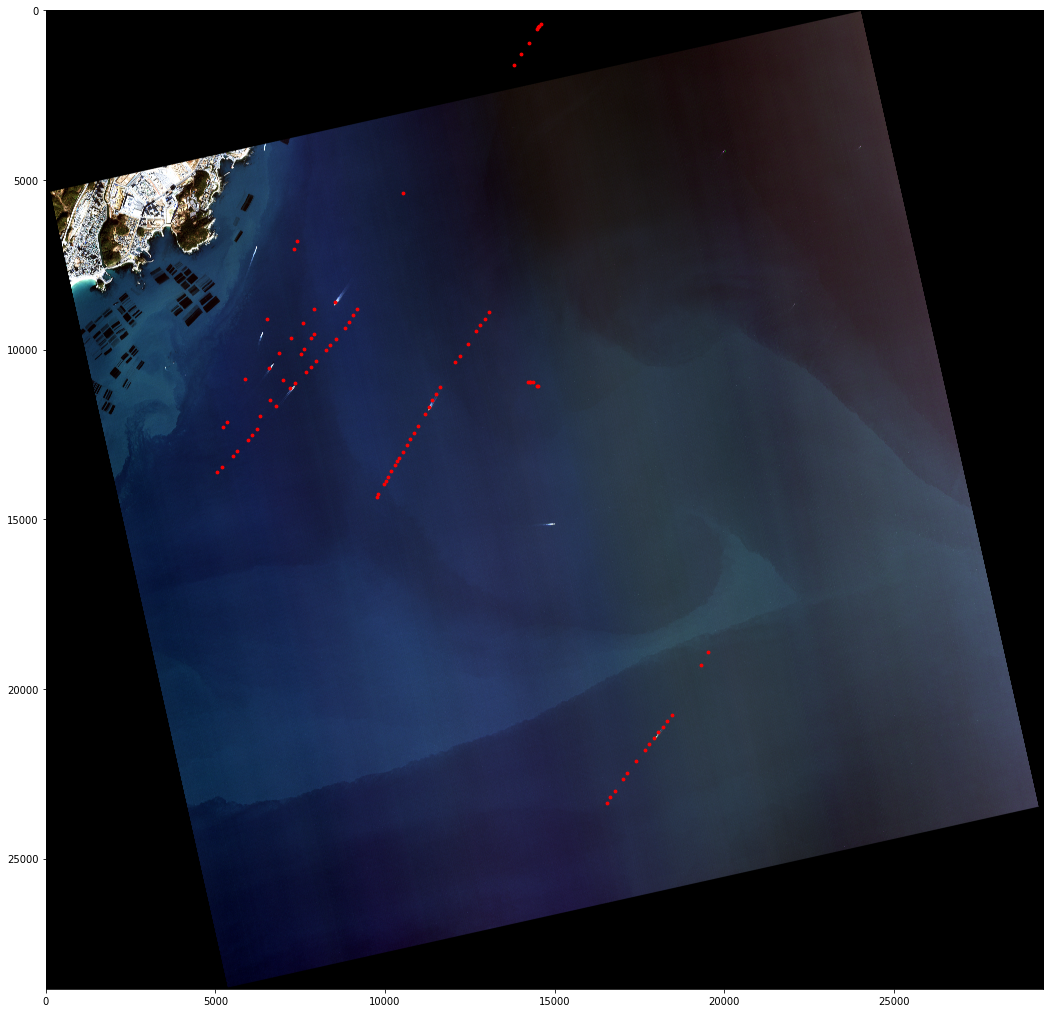

In [27]:
# Scatter Only 
# AIS 

plt.figure(figsize=(18,18))
plt.imshow(img_)
plt.scatter([i[1] for i in q_df['pixels']],[i[0] for i in q_df['pixels']], color='red',marker='o',s=8)

plt.savefig(args.img_output_scatter,dpi =800)
plt.show()

# Masking BBox in the land 

In [50]:
args.map_path
os.path.exists(args.map_path)

True

------------------- Eric Edited 


<Axes: >

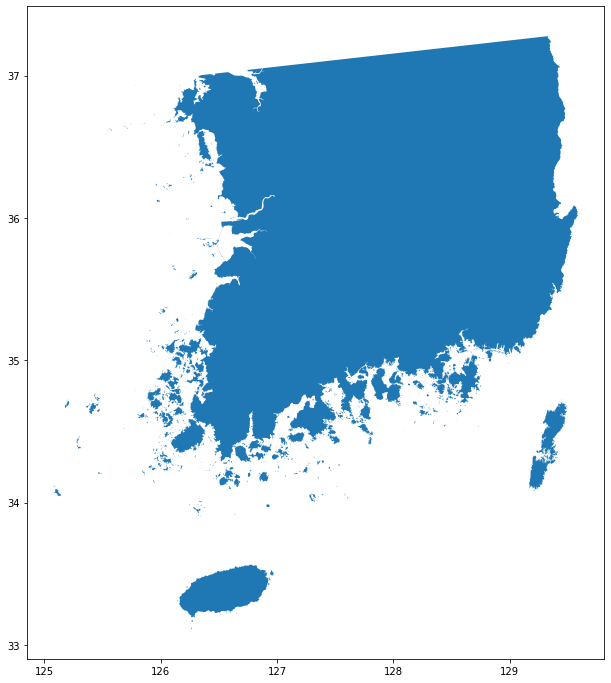

In [51]:
# Visualize Shape File !!
import geopandas as gpd
from shapely.geometry import Point
# Masking을 위한 shape 불러오기 
gdf=gpd.GeoDataFrame.from_file(args.map_path) #shapefile 불러오기

gpd.GeoSeries(gdf['geometry']).plot(figsize=(20,12)) #shapefile 플랏


In [52]:
import geopandas as gpd
from shapely.geometry import Point
# Masking을 위한 shape 불러오기 
gdf=gpd.GeoDataFrame.from_file(args.map_path) #shapefile 불러오기

# from pixel to utm
tmp_ =[] 
with rasterio.open(tf_path) as map_layer:
    for x,y in zip(M_['bbox x coord'].values, M_['bbox y coord'].values):
        
        x_coord,y_coord = map_layer.xy(y,x) # 여기 순서에 맞춰줘야, long,lat 좌표계가 맞음 
        tmp_.append([x_coord,y_coord])

tmp_1= []
ship_idxs = []
# from utm to latlon 
for idx,co in enumerate(tmp_):
    x,y = co[0],co[1]
    lat,lon = utm.to_latlon(x,y,52,"N")
    # print(lat,lon) # M_ 에서, 미리 설정되었던 AIS와 함께 좌표값 검증하였음

    print("progress : ", idx, " / ",len(tmp_))
    check=gdf['geometry'].contains(Point(lon,lat)) #특정 좌표 (long,lat)이 shapefile 다각형에 포함되는지 확인하기
    checkt=np.where(check == True)[0]
    
    if len(checkt) == 0:
        tmp_1.append(checkt)
        ship_idxs.append(idx)

progress :  0  /  184
progress :  1  /  184
progress :  2  /  184
progress :  3  /  184
progress :  4  /  184
progress :  5  /  184
progress :  6  /  184
progress :  7  /  184
progress :  8  /  184
progress :  9  /  184
progress :  10  /  184
progress :  11  /  184
progress :  12  /  184
progress :  13  /  184
progress :  14  /  184
progress :  15  /  184
progress :  16  /  184
progress :  17  /  184
progress :  18  /  184
progress :  19  /  184
progress :  20  /  184
progress :  21  /  184
progress :  22  /  184
progress :  23  /  184
progress :  24  /  184
progress :  25  /  184
progress :  26  /  184
progress :  27  /  184
progress :  28  /  184
progress :  29  /  184
progress :  30  /  184
progress :  31  /  184
progress :  32  /  184
progress :  33  /  184
progress :  34  /  184
progress :  35  /  184
progress :  36  /  184
progress :  37  /  184
progress :  38  /  184
progress :  39  /  184
progress :  40  /  184
progress :  41  /  184
progress :  42  /  184
progress :  43  /  18

In [53]:
# 마스킹하기 전, 탐색된 선박수
display(M_)

box index  bbox x coord  bbox y coord  bbox width  bbox height  \
0            0  11289.006836  11736.577148  137.462097    27.550625   
1           18  17964.523438  21425.134766  153.736755    27.958725   
2           54   7301.246582  11082.084961   53.936428    23.667095   
3           81   6700.061523  10417.964844   84.521576    23.278902   
4           91   8496.368164   8674.822266   44.160065    16.578196   
..         ...           ...           ...         ...          ...   
179        178   1224.939575   7043.976562  121.116440    25.131098   
180        179   4519.137207   5906.466797   23.784834     8.376174   
181        181    744.614441   7573.734863  372.736115    35.366833   
182        182   1746.569824   7977.555176   23.266745     8.155226   
183        183   1788.994995   9492.419922  805.769653   235.032227   

     bbox angle  bbox prob         mmsi  heading   turn  speed  \
0     -1.023753   0.983102  440124550.0    184.0  127.0   10.6   
1     -0.941664   0.917189  440061960.0    217.0    0.0   10.5   
2     -0.825432   0.727578  440110750.0    511.0 -128.0   10.8   
3     -1.142020   0.624665  440300740.0    511.0 -128.0    8.8   
4     -1.401928   0.533656  440120970.0    511.0 -128.0   14.7   
..          ...        ...          ...      ...    ...    ...   
179    1.560360   0.211841          NaN      NaN    NaN    NaN   
180    0.541356   0.208768          NaN      NaN    NaN    NaN   
181    1.478266   0.203653          NaN      NaN    NaN    NaN   
182   -0.530695   0.203035          NaN      NaN    NaN    NaN   
183   -0.490392   0.201850          NaN      NaN    NaN    NaN   

     ais x coord(pixel)  ais y coord(pixel)    ais lat    ais long  \
0                 11293               11682  35.163033  129.258752   
1                 18048               21280  35.119675  129.295680   
2                  7212               11143  35.165510  129.236352   
3                  6571               10538  35.168245  129.232840   
4                  8517                8609  35.176920  129.243552   
..                  ...                 ...        ...         ...   
179                   0                   0   0.000000    0.000000   
180                   0                   0   0.000000    0.000000   
181                   0                   0   0.000000    0.000000   
182                   0                   0   0.000000    0.000000   
183                   0                   0   0.000000    0.000000   

              ais time  
0    023-01-11 10:51:1  
1    023-01-11 10:51:0  
2    023-01-11 10:51:0  
3    023-01-11 10:50:5  
4    023-01-11 10:51:1  
..                 ...  
179                  0  
180                  0  
181                  0  
182                  0  
183                  0  

[184 rows x 16 columns]

In [59]:
# visualize the result 
M_masked = M_.iloc[ship_idxs]
# sav the csv 
M_masked.to_csv(args.csv_output_masked)
display(M_masked)

box index  bbox x coord  bbox y coord  bbox width  bbox height  \
0            0  11289.006836  11736.577148  137.462097    27.550625   
1           18  17964.523438  21425.134766  153.736755    27.958725   
2           54   7301.246582  11082.084961   53.936428    23.667095   
3           81   6700.061523  10417.964844   84.521576    23.278902   
4           91   8496.368164   8674.822266   44.160065    16.578196   
..         ...           ...           ...         ...          ...   
138        137   6381.334473   9490.129883   26.378059    18.450245   
143        142   3109.866455   7398.156738  138.207336    31.920765   
145        144   1828.174072  10066.507812  259.031372    66.370941   
175        174   5377.157227   4392.795898   11.470439     6.798670   
183        183   1788.994995   9492.419922  805.769653   235.032227   

     bbox angle  bbox prob         mmsi  heading   turn  speed  \
0     -1.023753   0.983102  440124550.0    184.0  127.0   10.6   
1     -0.941664   0.917189  440061960.0    217.0    0.0   10.5   
2     -0.825432   0.727578  440110750.0    511.0 -128.0   10.8   
3     -1.142020   0.624665  440300740.0    511.0 -128.0    8.8   
4     -1.401928   0.533656  440120970.0    511.0 -128.0   14.7   
..          ...        ...          ...      ...    ...    ...   
138   -1.336485   0.313686          NaN      NaN    NaN    NaN   
143   -0.205466   0.292312          NaN      NaN    NaN    NaN   
145   -0.541521   0.286597          NaN      NaN    NaN    NaN   
175    1.078130   0.220082          NaN      NaN    NaN    NaN   
183   -0.490392   0.201850          NaN      NaN    NaN    NaN   

     ais x coord(pixel)  ais y coord(pixel)    ais lat    ais long  \
0                 11293               11682  35.163033  129.258752   
1                 18048               21280  35.119675  129.295680   
2                  7212               11143  35.165510  129.236352   
3                  6571               10538  35.168245  129.232840   
4                  8517                8609  35.176920  129.243552   
..                  ...                 ...        ...         ...   
138                   0                   0   0.000000    0.000000   
143                   0                   0   0.000000    0.000000   
145                   0                   0   0.000000    0.000000   
175                   0                   0   0.000000    0.000000   
183                   0                   0   0.000000    0.000000   

              ais time  
0    023-01-11 10:51:1  
1    023-01-11 10:51:0  
2    023-01-11 10:51:0  
3    023-01-11 10:50:5  
4    023-01-11 10:51:1  
..                 ...  
138                  0  
143                  0  
145                  0  
175                  0  
183                  0  

[74 rows x 16 columns]

In [60]:
M_masked[0:10]

box index  bbox x coord  bbox y coord  bbox width  bbox height  bbox angle  \
0          0  11289.006836  11736.577148  137.462097    27.550625   -1.023753   
1         18  17964.523438  21425.134766  153.736755    27.958725   -0.941664   
2         54   7301.246582  11082.084961   53.936428    23.667095   -0.825432   
3         81   6700.061523  10417.964844   84.521576    23.278902   -1.142020   
4         91   8496.368164   8674.822266   44.160065    16.578196   -1.401928   
5         99  14313.578125  11016.852539   29.242365    12.173757    0.216588   
6        180   8560.395508   8560.247070  253.430923    37.764557   -1.092351   
7          1   2770.055176  10450.925781  251.120377    73.532944   -1.061116   
8          2   2055.579346   8643.152344  154.751877    20.837231   -0.541877   
9          3   2337.404541  10988.216797  250.343399    28.632814   -1.000305   

   bbox prob         mmsi  heading   turn  speed  ais x coord(pixel)  \
0   0.983102  440124550.0    184.0  127.0   10.6               11293   
1   0.917189  440061960.0    217.0    0.0   10.5               18048   
2   0.727578  440110750.0    511.0 -128.0   10.8                7212   
3   0.624665  440300740.0    511.0 -128.0    8.8                6571   
4   0.533656  440120970.0    511.0 -128.0   14.7                8517   
5   0.488706  440139020.0    511.0 -128.0    1.0               14201   
6   0.206832  440120970.0    511.0 -128.0   14.7                8517   
7   0.967445          NaN      NaN    NaN    NaN                   0   
8   0.961051          NaN      NaN    NaN    NaN                   0   
9   0.960114          NaN      NaN    NaN    NaN                   0   

   ais y coord(pixel)    ais lat    ais long           ais time  
0               11682  35.163033  129.258752  023-01-11 10:51:1  
1               21280  35.119675  129.295680  023-01-11 10:51:0  
2               11143  35.165510  129.236352  023-01-11 10:51:0  
3               10538  35.168245  129.232840  023-01-11 10:50:5  
4                8609  35.176920  129.243552  023-01-11 10:51:1  
5               10947  35.166312  129.274730  023-01-11 10:49:5  
6                8609  35.176920  129.243552  023-01-11 10:51:1  
7                   0   0.000000    0.000000                  0  
8                   0   0.000000    0.000000                  0  
9                   0   0.000000    0.000000                  0

# Masked Visualization

#-------------- 0.0135
#-------------- 0.0270
#-------------- 0.0405
#-------------- 0.0541
#-------------- 0.0676
#-------------- 0.0811
#-------------- 0.0946
#-------------- 0.1081
#-------------- 0.1216
#-------------- 0.1351
#-------------- 0.1486
#-------------- 0.1622
#-------------- 0.1757
#-------------- 0.1892
#-------------- 0.2027
#-------------- 0.2162
#-------------- 0.2297
#-------------- 0.2432
#-------------- 0.2568
#-------------- 0.2703
#-------------- 0.2838
#-------------- 0.2973
#-------------- 0.3108
#-------------- 0.3243
#-------------- 0.3378
#-------------- 0.3514
#-------------- 0.3649
#-------------- 0.3784
#-------------- 0.3919
#-------------- 0.4054
#-------------- 0.4189
#-------------- 0.4324
#-------------- 0.4459
#-------------- 0.4595
#-------------- 0.4730
#-------------- 0.4865
#-------------- 0.5000
#-------------- 0.5135
#-------------- 0.5270
#-------------- 0.5405
#-------------- 0.5541
#-------------- 0.5676
#-------------- 0.5811
#----------

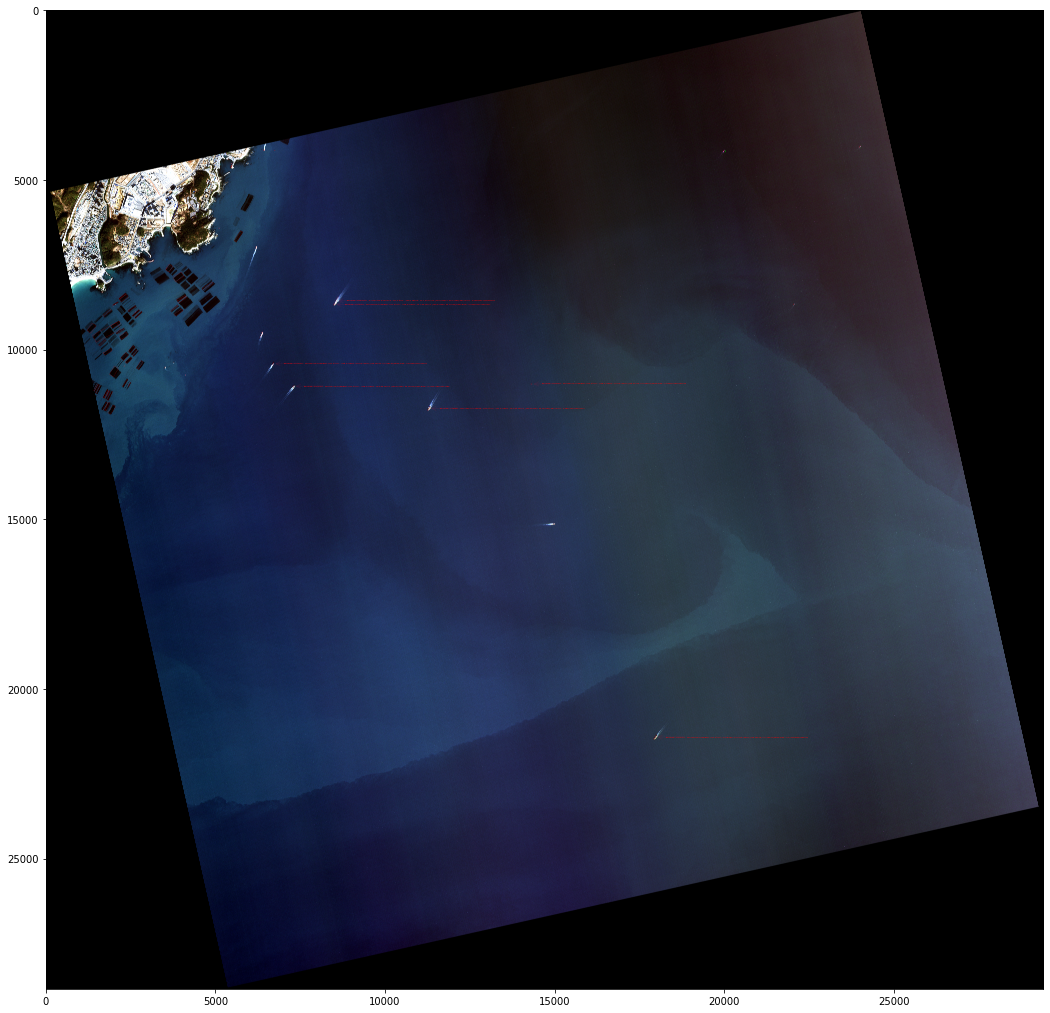

In [58]:
# visualize the result with masking 
# original image 
img_path = args.img_path
img_ = Image.open(img_path)

plt.figure(figsize=(18,18))
plt.imshow(img_)
ax = plt.gca()

#------------------------------------
# Bbox 
bboxes_ = [] 
cnt = 0
box_cnt = 0

# Label
plt_txts = []

# M_masked
for i,row in M_masked.iterrows():
    box_idx = row['box index']
    x = row['bbox x coord']
    y = row['bbox y coord']
    width = row['bbox width']
    height = row['bbox height']
    angle_ = row['bbox angle']
    prob_ = row['bbox prob']

    mmsi_ = row['mmsi']
    heading_ = row['heading']
    turn_ = row['turn']
    speed_ = row['speed']
    lat_ = row['ais lat']
    lon_ = row['ais long']

    
    
    box_cnt+=1
    print(f"#-------------- {box_cnt / len(M_masked):.4f}")
    path_obj = patches.Rectangle((x-width*0.5,y-height*0.5), width, height, linewidth=0.1, edgecolor="red", fill=False,
                                rotation_point="center",
                                angle=angle_*180/np.pi)
    
    ax.add_patch(path_obj)

    if (lat_ ==0) & (lon_ ==0):
        pass
    else:
        name = f'bbox idx : {box_idx} mmsi : {mmsi_} heading : {heading_} turn : {turn_} speed : {speed_} ais coord: {lon_,lat_} bbox prob : {prob_}'
        plt_txts.append( plt.text(x, y, name, fontsize =2,color='red') ) 


adjust_text(plt_txts, 
            force_points=3,
            arrowprops={'arrowstyle' : '->', 
                        'color' : 'crimson',  
                        'alpha' : 0.1}
            )
#------------------------------------

plt.imshow(img_)
plt.savefig(args.img_output_masked,dpi =1200 )
plt.show()
#------------------------------------

In [ ]:
# # Compare Experiment No masking 

# # visualize the result 
# # original image 
# img_path = args.img_path
# img_ = Image.open(img_path)

# plt.figure(figsize=(18,18))
# plt.imshow(img_)
# ax = plt.gca()

# #------------------------------------
# # Bbox 
# bboxes_ = [] 
# cnt = 0
# box_cnt = 0


# # No_masked
# for i,row in M_.iterrows():
#     x = row['bbox x coord']
#     y = row['bbox y coord']
#     width = row['bbox width']
#     height = row['bbox height']
#     angle_ = row['bbox angle']
    
#     box_cnt+=1
#     print(f"#-------------- {box_cnt / len(M_):.4f}")
#     path_obj = patches.Rectangle((x-width*0.5,y-height*0.5), width, height, linewidth=0.1, edgecolor="red", fill=False,
#                                 rotation_point="center",
#                                 angle=angle_*180/np.pi)
    
#     ax.add_patch(path_obj)
# #------------------------------------


# plt.savefig(args.img_path.replace(".png" ,"_output_v2_1207_no_masking.png"),dpi =1200 )
# plt.show()

In [ ]:
# M_['land_included'] = tmp_1

In [ ]:
args.final_merge.replace("_PS.csv", "_PS_masking.csv")

'/mnt/hdd/eric/.tmp_ipy/00.Data/AO/0-Pusan-2023-AO/C1_20230116015105_10110_00006119_L1G_PS/0-Pusan-2023-AO_3_C1_20230116015105_10110_00006119_L1G.csv'

In [ ]:
# import os 
# M_.to_csv(os.path.join("/mnt/hdd/eric/.tmp_ipy/00.Data/tmp_","test1.csv"),index=False )

In [ ]:
# import os 
# M_.to_csv(args.final_merge,index=False )